# MSBD5001 (L1) - Foundations of Data Analytics
# Kaggle in-class competition

## Contents
* Introduction
* Material
 * Data interpretation
 * Data visualization
 * Feature generation
 * Featute analysis
* Model
 * Model construction
 * Model evaluation
* Results

## Introduction
The task is to construct a model based on the time series of traffic speed per hour for a major road in Hong Kong from 2017 to 2018 and make accurate predictions for some missing values or forecasting. The challenge is that test set is unknown, which makes it very easy to train the model to overfit. The achieved outcome should be that the model is able to give right prediction for test set and performs consistent in the train set and test set. 

The followings are the used packages.

In [1]:
import requests
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
from datetime import datetime
from bs4 import BeautifulSoup
from xgboost import plot_importance
from pandas.plotting import scatter_matrix
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose

## Material
### Data interpretation

In [2]:
# load data as pandas dataframe.
fmt = lambda dates: datetime.strptime(dates, "%d/%m/%Y %H:%M")
data = pd.read_csv('./data/train.csv', index_col = [0], parse_dates = [1], date_parser = fmt)
test = pd.read_csv('./data/test.csv', index_col = [0], parse_dates = [1], date_parser = fmt)

In this part, we interpret the data. First, look at the data. It consists of two columns, date and speed. For each object, date is the date and time of the average speed which is down to hours.

In [3]:
# information of train set.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14006 entries, 0 to 14005
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    14006 non-null  datetime64[ns]
 1   speed   14006 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 328.3 KB


In [4]:
data.head(10)

,date,speed
id,,
0,2017-01-01 00:00:00,43.002930
1,2017-01-01 01:00:00,46.118696
2,2017-01-01 02:00:00,44.294158
3,2017-01-01 03:00:00,41.067468
4,2017-01-01 04:00:00,46.448653
5,2017-01-01 05:00:00,46.797766
6,2017-01-01 06:00:00,44.404925
7,2017-01-01 07:00:00,45.255897
8,2017-01-01 08:00:00,45.680859


In [5]:
data.tail(10)

,date,speed
id,,
13996,2018-12-31 04:00:00,46.949353
13997,2018-12-31 07:00:00,39.646151
13998,2018-12-31 08:00:00,19.509383
13999,2018-12-31 09:00:00,20.291883
14000,2018-12-31 10:00:00,33.851121
14001,2018-12-31 12:00:00,19.865269
14002,2018-12-31 15:00:00,17.820375
14003,2018-12-31 16:00:00,12.501851
14004,2018-12-31 18:00:00,15.979319


In [6]:
# dimension of train set.
data.shape

(14006, 2)

In [7]:
# dimension of test set.
test.shape

(3504, 1)

The dataset totally loses 20.0571% of the objects. Although it was sampled in the part of objects of 2018, the part of 2017 also has 10 missing values. Fortunately, it does not have NA or any abnormal values since the minimum average speed is 2.573417 and maximum average speed is 53.161286, both are realistic. Therefore, there are no need to conduct data cleaning, but we should consider whether to complete of missing values.

It is impossible to complete all the missing values that account for more than 20% of the total data. Doing so would greatly mislead the model. Besides, we want to use as much data as possible. However, time series requires the time stamps to be equally spaced.

Therefore, instead of using time series, we use regression to do interpolation fit with date and time features.

In [8]:
# total missing values.
1 - data.shape[0] / (24 * 365 * 2)

0.20057077625570774

In [9]:
# missing values in 2017.
24 * 365 - sum(data["date"].dt.year == 2017)

10

In [10]:
# whether dataset has NA data.
data.isna().value_counts()

date   speed
False  False    14006
dtype: int64

In [11]:
# descriptive statistics of speed.
data.describe()

,speed
count,14006.000000
mean,32.779118
std,13.573813
min,2.573417
25%,19.301089
50%,36.580595
75%,45.877665
max,53.161286


### Data visualization

In this part, we visualize the data to see some interesting patterns.

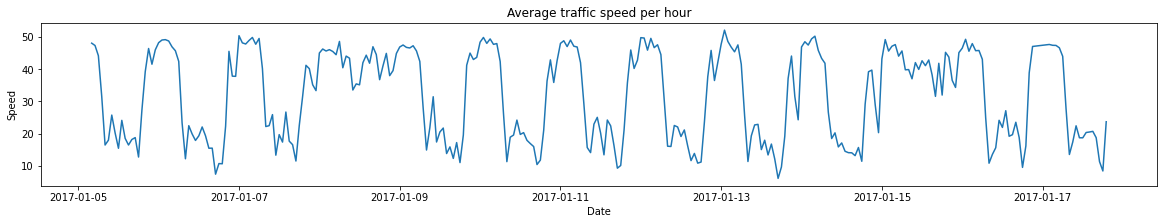

In [12]:
# Plot the time series between 100 and 400 to see the trend.
xx = data[100:400]["date"]
yy = data[100:400]["speed"]
plt.figure(figsize = (20, 3))
plt.plot(xx, yy)
plt.xlabel("Date")
plt.ylabel("Speed")
plt.title("Average traffic speed per hour")
plt.show()

As can be seen from the figure above, the average speed changes regularly and periodicity significantly over time. It has regular peaks which seems to have periodic cycle of 24 hours, and regular table mountains about 2017-01-09 and 2017-01-15 which are exactly seven days or a week apart.

<Figure size 432x288 with 0 Axes>

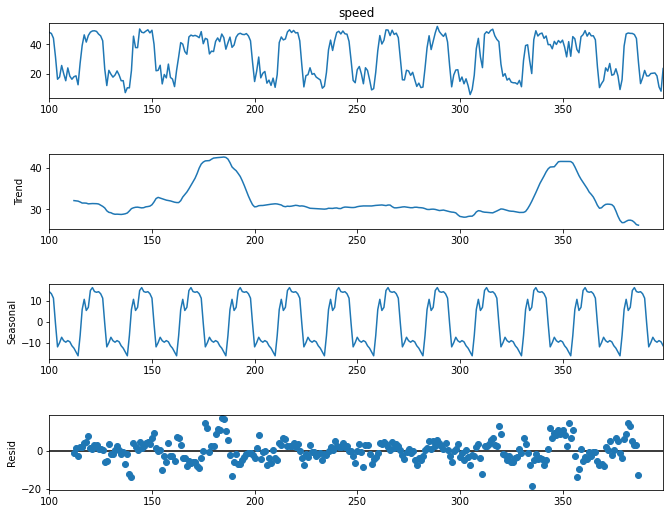

In [13]:
# decompose the time series to see whether there are strong seasonal components.
decomposition = seasonal_decompose(data[100:400]["speed"], period = 24)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 8)

<Figure size 432x288 with 0 Axes>

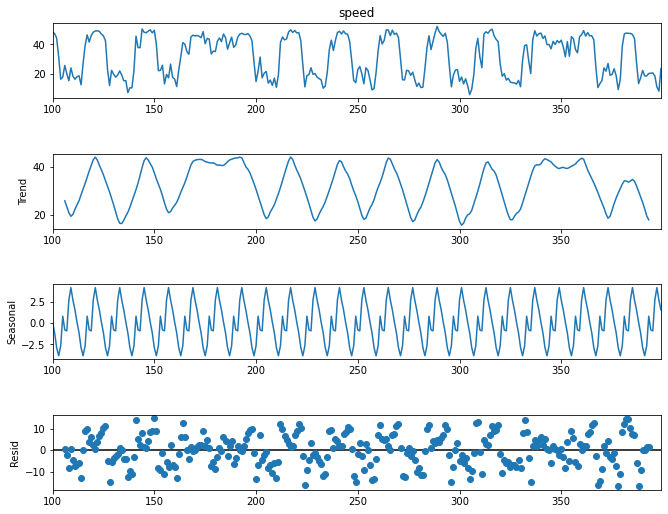

In [14]:
decomposition = seasonal_decompose(data[100:400]["speed"], period = 12)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 8)

As can be seen from the figures above, the time series has strong periodic cycles. Intuitively, we can think that the period should be 24 hours in common senses. However, the trend still has periodic cycles. Additionally, the residuals in the first figure are still not random. Choosing period to be 12 hours, residuals are now random.

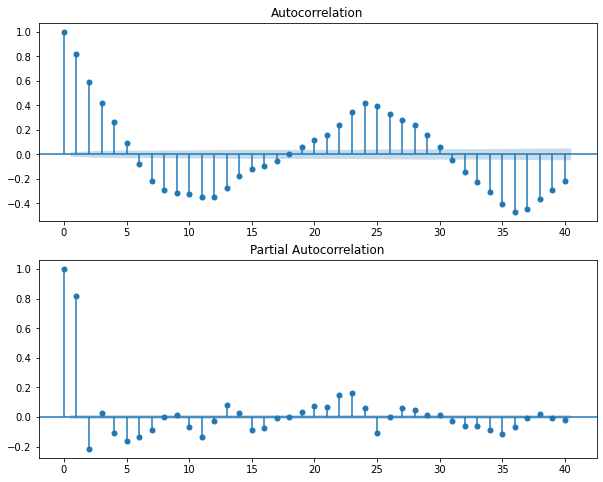

In [15]:
# ACF and PACF.
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data.speed, lags = 40, ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data.speed, lags = 40, ax = ax2)

Also, periodicity is fairly obvious.

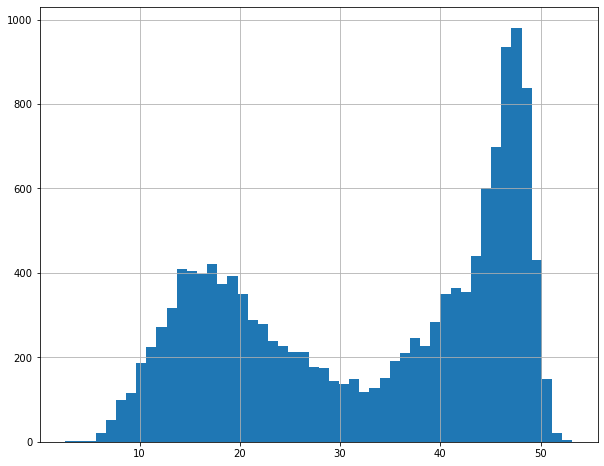

In [16]:
# plot the histogram of average speed.
data["speed"].hist(bins=50, figsize=(10, 8))
plt.show()

Histogram shows a bimodal distribution.

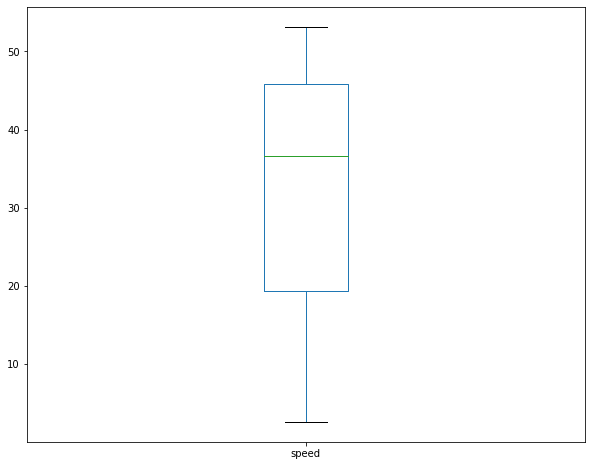

In [17]:
# plot boxplot of average speed.
data["speed"].plot.box(figsize=(10,8))
plt.show()

### Feature generation

In this part, we generate features for model construction. In common sense, the average speed on the road depends on a number of factors, traffic flow, weather, holidays or festivals, and so on. Actually, all these factors are related to date and time. Therefore, we can generate these factors using date and time.

In [18]:
# check whether a object in the dataset is holiday.
def isholiday(year):
    url = "https://www.gov.hk/en/about/abouthk/holiday/" + str(year) + ".htm"
    r = requests.get(url)
    b = BeautifulSoup(r.text, "html.parser")
    t = b.find_all("table")
    df = pd.read_html(str(t))[0]
    df[1] = df[1] + " " + str(year)
    return pd.to_datetime(df[1], dayfirst = True)[1:]

In [19]:
h2017 = isholiday(2017)
h2018 = isholiday(2018)
h = pd.concat([h2017, h2018], axis = 0, ignore_index = True)

In [20]:
# check whether a object in the dataset is rainy or windy day.
# since tt never snows in Hong Kong. Only rain and strong wind can affect the average speed.
def getweather():
    y = ["2017", "2018"]
    m =["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12"]
    url = "https://www.hko.gov.hk/en/wxinfo/pastwx/metob"
    w = pd.DataFrame({},columns=["year", "month", "day", "rain", "wind"], index = range(365 * 2))

    idx = 0
    for i in y:
        for j in m:
            temp = url + i + j + ".htm"
            r = requests.get(temp)
            b = BeautifulSoup(r.text, "lxml")
            t = b.find_all("table")
            t0 = t[0].find_all("tr")
            t1 = t[1].find_all("tr")

            for tt1, tt2 in zip(t0[2:-3], t1[1:-3]):
                w.iloc[idx, 0] = i
                w.iloc[idx, 1] = j
                ttt1 = tt1.find_all("td")
                ttt2 = tt2.find_all("td")
                w.iloc[idx, 2] = ttt1[0].contents[0]
                w.iloc[idx, 3] = ttt1[8].contents[0]
                w.iloc[idx, 4] = ttt2[6].contents[0]
                idx += 1
    num = w.shape[0]
    for i in range(num):
        w.wind[i] = float(w.wind[i])
        if w.rain[i] == "-" or w.rain[i] == "Trace":
            w.rain[i] = 0
        else:
            w.rain[i] = float(w.rain[i])
    return w

In [21]:
w = getweather()

In [22]:
# generate features.
def generate_feature(df, h, w):
    df["hfd"] = df["date"].dt.hour # hour of a day
    df["dfw"] = df["date"].dt.dayofweek + 1 # day of a week
    df["dfm"] = df["date"].dt.day # day of a month
    df["dfy"] = df["date"].dt.dayofyear # day of a year
    df["wfy"] = np.int64(df["date"].dt.isocalendar().week) # week of a year
    df["mfy"] = df["date"].dt.month # month of a year
    df["qfy"] = df["date"].dt.quarter # quarter of a year
    
    df.loc[df["dfw"].isin([1, 2, 3, 4, 5]), "dwss"] = 1 # workdays
    df.loc[df["dfw"].isin([6]), "dwss"] = 2 # Saturday
    df.loc[df["dfw"].isin([7]), "dwss"] = 3 # Sunday

    df.loc[df["hfd"].isin([0, 1, 2, 3, 4, 5, 6, 21, 22, 23]), "hnd"] = 1 # night hour
    df.loc[df["hfd"].isin([9, 10, 13, 14, 15, 19, 20]), "hnd"] = 2 # day hour
    df.loc[df["hfd"].isin([7, 8, 11, 12, 16, 17, 18]), "hnd"] = 3 # rush hour
    
    length = df.shape[0]

    ish = [0 for i in range(length)]
    for i in h:
        for idx, item in enumerate(df["date"]):
            y = item.year
            m = item.month
            d = item.day
            hy = int(i.year)
            hm = int(i.month)
            hd = int(i.day)
            if y == hy and m == hm and d == hd:
                ish[idx] = 1
    df["ish"] = ish

    rain = [0 for i in range(length)]
    wind = [0 for i in range(length)]
    num = w.shape[0]
    for i in range(num):
        for idx, item in enumerate(df["date"]):
            y = item.year
            m = item.month
            d = item.day
            wy = int(w.year[i])
            wm = int(w.month[i])
            wd = int(w.day[i])
            if y == wy and m == wm and d == wd:
                rain[idx] = float(w.rain[i])
                wind[idx] = float(w.wind[i])
    df["rain"] = rain
    df["wind"] = wind
    
    x = df[["hfd", "dfw", "dfm", "dfy", "wfy", "mfy", "qfy", "dwss", "hnd", "ish", "rain", "wind"]]
    return x

In [23]:
x = generate_feature(data, h, w)
y = data["speed"]
x_test = generate_feature(test, h, w)

### Featute analysis

In this part, we analyse whether the features we generate are useful or related to the average speed. The following is the attribute information of the features.
* hfd: hour of a day, domain [0, 23], int
* dfw: day of a week, domain [1, 7], int
* dfm: day of a month, domain [1, 31], int
* dfy: day of a year, domain [1, 365], int
* wfy: week of a year, domain [1, 52], int
* mfy: month of a year, domain [1, 12], int
* qfy: quarter of a year, domain [0, 23], int
* dwss: day of weekdays, Saturday, and Sunday, domain {1.0, 2.0, 3.0}, 1.0 for weekdays, 2.0 for Saturday, and 3.0 for Sunday
* hnd: hour of night, day, or rush hour, domain {1.0, 2.0, 3.0}, 1.0 for night hour, 2.0 for day hour, and 3.0 for rush hour
* ish: whether hours in a holiday, domain {0.0, 1.0}, 0.0 for non-holiday and 1.0 for holiday
* rain: day rainfall (mm)
* wind: wind speed (km/h)

In [24]:
x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14006 entries, 0 to 14005
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hfd     14006 non-null  int64  
 1   dfw     14006 non-null  int64  
 2   dfm     14006 non-null  int64  
 3   dfy     14006 non-null  int64  
 4   wfy     14006 non-null  int64  
 5   mfy     14006 non-null  int64  
 6   qfy     14006 non-null  int64  
 7   dwss    14006 non-null  float64
 8   hnd     14006 non-null  float64
 9   ish     14006 non-null  int64  
 10  rain    14006 non-null  float64
 11  wind    14006 non-null  float64
dtypes: float64(4), int64(8)
memory usage: 1.4 MB


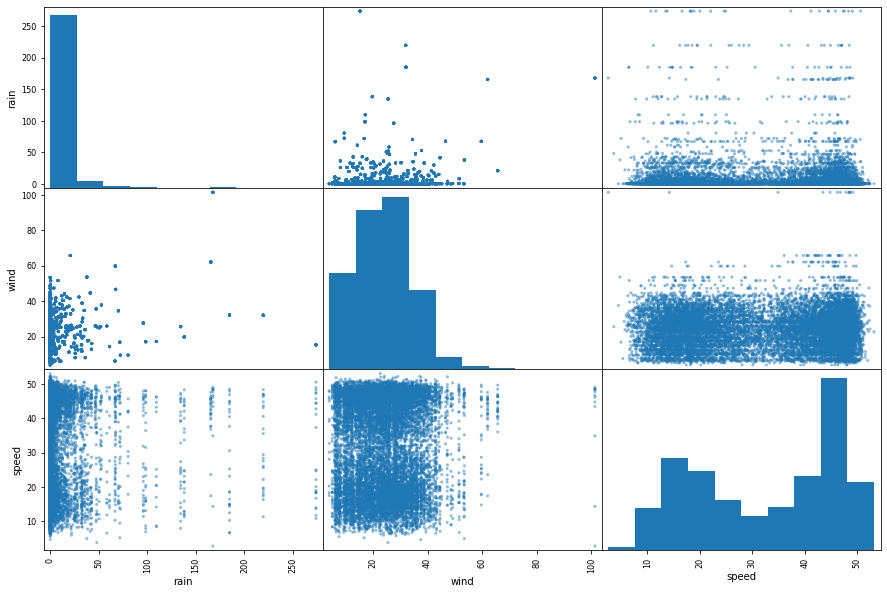

In [25]:
# plot scatter plot among attributes rain, wind, and speed.
temp = x.copy(deep = True)
temp["speed"] = y.copy(deep = True)
attr = ["rain", "wind", "speed"]
scatter_matrix(temp[attr], figsize = (15, 10))
plt.show()

From the above figure, we cannot see a clear relationship between rain and average speed, nor between wind and average speed.

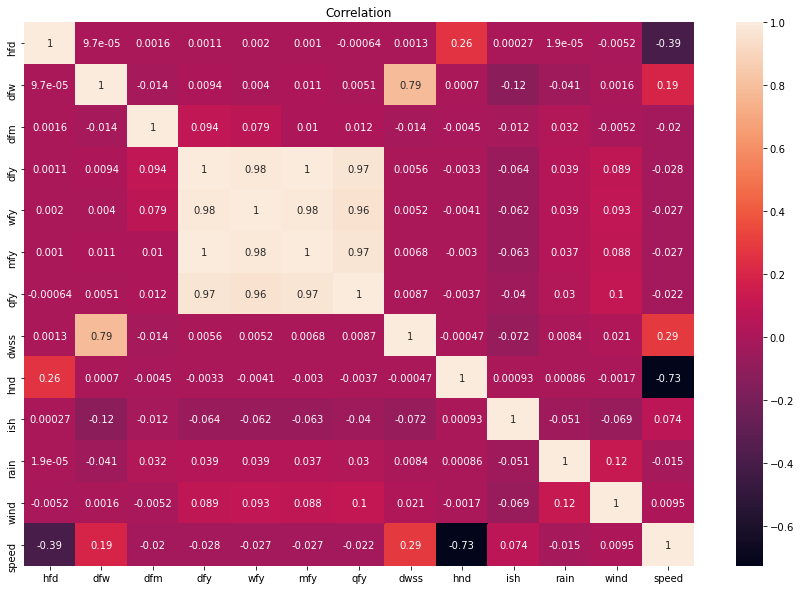

In [26]:
# plot correlation matrix.
plt.figure(figsize = (15, 10))
sns.heatmap(temp.corr(), annot = True)
plt.title("Correlation")
plt.show()

From the above figure, we can see average speed is more or less related to these features, especially hour of a day, day of weekdays, Saturday, or Sunday, hour of night or day, and so on. Besides, day of year, week of year, month of year, and quarter of year have strong multicollinearity.

## Model
### Model construction

In this part, we build our model. There are totally 14006 onjects in the dataset. Since we conduct interpolation vs rather than extrapolation, we do not have to use train_test_split in the module sklearn.model_selection to split the model into train set, validation set, nor test set. Just use all the objects.

In [27]:
# split the data into train set and validation set.
x_train = x[:9805].copy(deep = True) # 70%
x_valid = x[9805:].copy(deep = True) # 30%
y_train = y[:9805].copy(deep = True) # 70%
y_valid = y[9805:].copy(deep = True) # 30%

In [41]:
# tune the paramaters with Grid Search
paramT = {#"learning_rate": [0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2, 0.22, 0.24, 0.26, 0.28, 0.3, 0.32, 0.34, 0.36, 0.38, 0.4]
          #"n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200]
          #"max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
          #"min_child_weight": [1, 2, 3, 4, 5, 6]
          #"gamma": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
          #"subsample": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
          #"colsample_bytree": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
          #"reg_lambda": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
          "reg_alpha": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
         }
params = {"learning_rate": 0.08,
          "n_estimators": 1000,
          "max_depth": 12,
          "min_child_weight": 1,
          "gamma": 0,
          "subsample": 1,
          "colsample_bytree": 1,
          "reg_lambda": 4,
          "reg_alpha": 7,
          "seed": 168,
          "objective": "reg:squarederror"
         }
model = xgb.XGBRegressor(**params)
modelGS = GridSearchCV(estimator = model, param_grid = paramT, n_jobs = 4)
modelGS.fit(x, y)
print("Best parameter: {0}".format(modelGS.best_params_), "\n")
print("Best score: {0}".format(modelGS.best_score_), "\n")

Best parameter: {'reg_alpha': 4} 

Best score: 0.9189907404860399 



In [71]:
# initialize the model.
params = {"learning_rate": 0.08,
          "n_estimators": 1000,
          "max_depth": 12,
          "min_child_weight": 1,
          "gamma": 0.01,
          "subsample": 1,
          "colsample_bytree": 1,
          "reg_lambda": 4,
          "reg_alpha": 7,
          "seed": 168,
          "objective": "reg:squarederror"
         }
model = xgb.XGBRegressor(**params)

In [45]:
# fit the model
model.fit(x_train, y_train, eval_set = [(x_train, y_train), (x_valid, y_valid)], early_stopping_rounds = 50)

[0]	validation_0-rmse:32.2634	validation_1-rmse:32.2953
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:29.7417	validation_1-rmse:29.7722
[2]	validation_0-rmse:27.4244	validation_1-rmse:27.4533
[3]	validation_0-rmse:25.2963	validation_1-rmse:25.328
[4]	validation_0-rmse:23.3404	validation_1-rmse:23.375
[5]	validation_0-rmse:21.5446	validation_1-rmse:21.5835
[6]	validation_0-rmse:19.8955	validation_1-rmse:19.9386
[7]	validation_0-rmse:18.382	validation_1-rmse:18.4301
[8]	validation_0-rmse:16.9939	validation_1-rmse:17.0501
[9]	validation_0-rmse:15.7202	validation_1-rmse:15.7839
[10]	validation_0-rmse:14.5539	validation_1-rmse:14.6269
[11]	validation_0-rmse:13.4836	validation_1-rmse:13.5684
[12]	validation_0-rmse:12.5065	validation_1-rmse:12.603
[13]	validation_0-rmse:11.6116	validation_1-rmse:11.7204
[14]	validation_0-rmse:10.7917	validation_1-rmse:10.9108


XGBRegressor(gamma=0.01, learning_rate=0.08, max_depth=10, n_estimators=1000,
             objective='reg:squarederror', reg_alpha=7, reg_lambda=4, seed=168)

In [72]:
# fit the model
model.fit(x, y)

XGBRegressor(gamma=0.01, learning_rate=0.08, max_depth=12, n_estimators=1000,
             objective='reg:squarederror', reg_alpha=7, reg_lambda=4, seed=168)

### Model evaluation

In this part, we evaluate the constructed model.

In [73]:
# make predictions.
pred = model.predict(x)

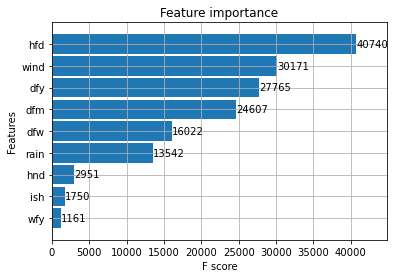

In [51]:
# plot the importance of features.
ipt = plot_importance(model, height = 0.9)

From the above figure, not surprisingly, we can find the more relevant the features are to the average speed, the more important they are.

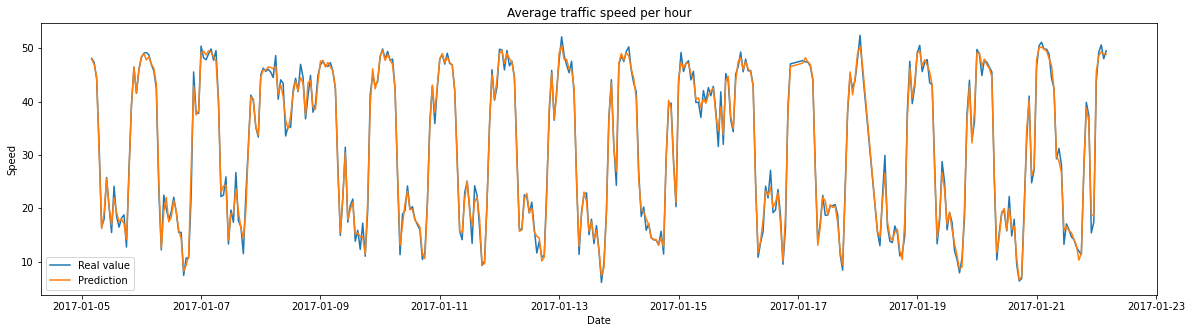

In [74]:
# compare the predictions with real average speed.
xx = data[100:500]["date"]
yy1 = y[100:500]
yy2 = pred[100:500]
plt.figure(figsize = (20, 5))
plt.plot(xx, yy1)
plt.plot(xx, yy2)
plt.legend(["Real value","Prediction"])
plt.xlabel("Date")
plt.ylabel("Speed")
plt.title("Average traffic speed per hour")
plt.show()

From the above two figures, we can see the model performs well. The predictions are very close to the real values.

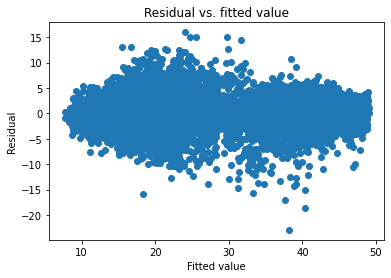

In [57]:
# check whether the residuals are random.
residual = y - pred
plt.scatter(pred, residual)
plt.xlabel("Fitted value")
plt.ylabel("Residual")
plt.title("Residual vs. fitted value")
plt.show()

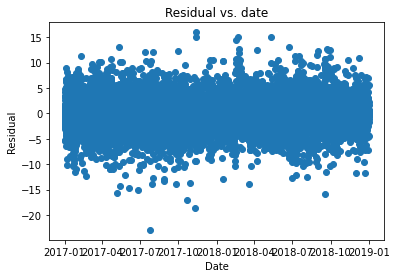

In [59]:
# check whether the residuals are independent of date.
plt.scatter(data["date"], residual)
plt.xlabel("Date")
plt.ylabel("Residual")
plt.title("Residual vs. date")
plt.show()

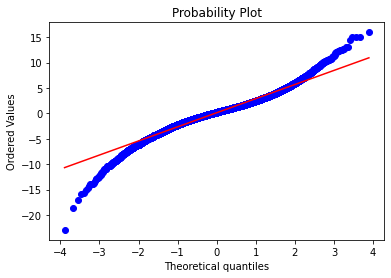

In [61]:
stats.probplot(residual, dist = "norm", plot = plt)
plt.show()

From the above three figures, we can see the residuals are random and generally normally distributed. It means the model perfroms well and can well explain most of the variations in the data.

## Results

In this part, we finally obtain the predictions for the test set.

In [76]:
# make predictions for test set.
prediction = model.predict(x_test)
numID = [i for i in range(x_test.shape[0])]
preddict = {"id": numID, "speed": prediction}
pred_test = pd.DataFrame(preddict)

In [78]:
pred_test.head(20)

,speed
0,47.741829
1,47.997223
2,37.517170
3,28.489683
4,43.116764
5,24.582216
6,17.341259
7,49.135452
8,47.752586
9,29.799736


In [80]:
# write to csv file.
pred_test.to_csv("./submission.csv", index = False, sep = ",")